In [1]:
# Imports
import numpy as np
import torch

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic

from sklearn.linear_model import LassoLarsIC, LassoCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train, rand_idx = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.05, random=True, return_idx=True)

In [4]:
# Making data
estimator = LassoLarsIC(fit_intercept=False)
#estimator = LassoCV()

config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 3}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [5]:
train_dynamic(model, X_train, y_train, optimizer, 5000, log_dir='runs/testing/')

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1625     32.50%             110s   -1.51e+01   8.38e-05   2.21e-06   1.74e+00 Updating mask.
       1825     36.50%              61s   -1.51e+01   8.41e-05   2.44e-06   1.45e+00 Updating mask.
       2125     42.50%              71s   -1.51e+01   8.38e-05   1.87e-06   1.44e+00 Updating mask.
       2525     50.50%               0s   -1.51e+01   8.37e-05   1.43e-06   1.44e+00 Updating mask.
       3025     60.50%               0s   -1.51e+01   8.37e-05   1.26e-06   1.44e+00 Updating mask.
5


In [8]:
df_part1 = load_tensorboard('runs/testing/')

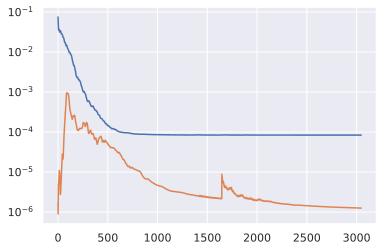

In [9]:
plt.semilogy(df_part1.index, df_part1['MSE_0'])
plt.semilogy(df_part1.index, df_part1['Regression_0'])

In [10]:
df_part1.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11'],
      dtype='object')

(1.3, 6)

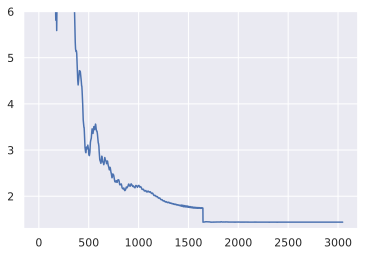

In [11]:
plt.plot(df_part1.index, df_part1['L1_0'])
plt.ylim([1.3, 6])

In [12]:
coeff_keys = [key for key in df_part1.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df_part1.keys() if key[:6]=='scaled']

In [13]:
coeff_keys

['coeff_0_0',
 'coeff_0_1',
 'coeff_0_2',
 'coeff_0_3',
 'coeff_0_4',
 'coeff_0_5',
 'coeff_0_6',
 'coeff_0_7',
 'coeff_0_8',
 'coeff_0_9',
 'coeff_0_10',
 'coeff_0_11']

(-2, 2)

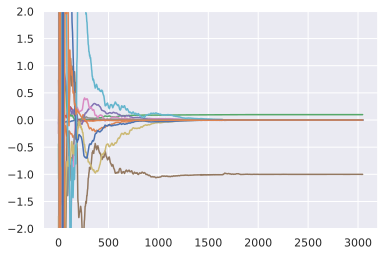

In [14]:
plt.plot(df_part1[coeff_keys])
plt.ylim([-2, 2])

(-2, 2)

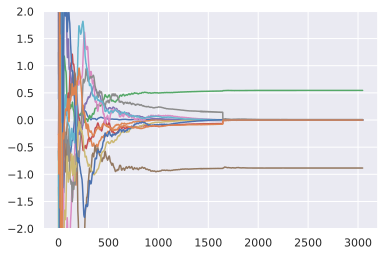

In [15]:
plt.plot(df_part1[scaled_coeff_keys])
plt.ylim([-2, 2])

In [18]:
active_map = df_part1[coeff_keys][::10]
active_map[active_map!=0.0] = 1.0

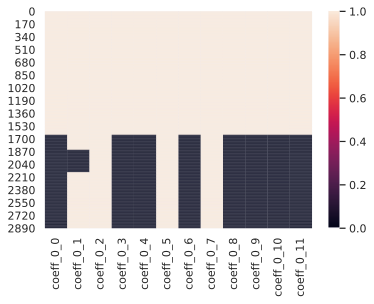

In [19]:
sns.heatmap(active_map)

In [42]:
df_part1['L1_0'].idxmin()

1362

In [58]:
model.constraints.sparsity_mask

[tensor([False,  True,  True, False, False,  True, False,  True, False, False,
         False, False])]

In [59]:
model.constraints.coeff_vector

[tensor([[-0.0014],
         [ 0.0981],
         [-0.9842],
         [ 0.0013]], grad_fn=<MmBackward>)]

In [60]:
model.sparsity_estimator.coef_

array([ 0.        , -0.00497956,  0.55069429,  0.        ,  0.        ,
       -0.8465937 ,  0.        ,  0.03108972,  0.        ,  0.        ,
        0.        ,  0.        ])

In [30]:
from sklearn.cluster import KMeans

In [31]:
kmeans = KMeans(n_clusters=2)

In [32]:
kmeans.fit_predict(np.abs(model.sparsity_estimator.coef_[:, None]))

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [41]:
train_dynamic(model, X_train, y_train, optimizer, 1000, loss_func_args={'patience': 50, 'initial_idx': 200}, log_dir='runs/part_3/')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
         50      5.00%              29s   -1.51e+01   8.37e-05   1.33e-06   1.44e+00 

KeyboardInterrupt: 

In [22]:
model.constraints.sparsity_mask

[tensor([False, False,  True, False, False,  True, False,  True, False, False,
         False, False])]

In [23]:
model.constraints.coeff_vector

[tensor([[ 9.8826e-02],
         [-1.0073e+00],
         [ 7.8898e-04]], grad_fn=<MmBackward>)]

In [24]:
df_part2 = load_tensorboard('runs/part_3/')

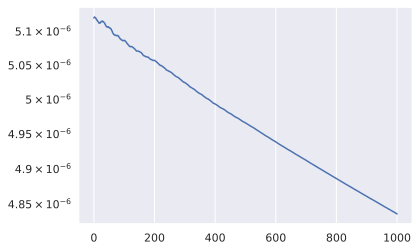

In [25]:
#plt.semilogy(df_part2.index, df_part2['MSE_0'])
plt.semilogy(df_part2.index, df_part2['Regression_0'])

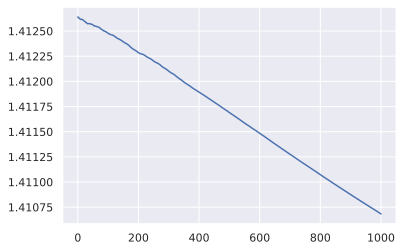

In [26]:
plt.plot(df_part2.index, df_part2['L1_0'])